In [1]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = "COMPSCI 682/compsci-682-project"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
# %cd /content/drive/My\ Drive/$FOLDERNAME/datasets
# !wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
# !wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt
# !wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/test_filtered.txt
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/COMPSCI 682/compsci-682-project


In [2]:
# Setting up locale
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
%load_ext autoreload
%autoreload 2

from src.configuration import *
from src.dataset import *
from src.networks import *
from src.training import *
from src.evaluation import *
from src.utils import *
import src.preprocess as pp

In [4]:
# Setting up environment for using GPU or CPU as per availability
dtype = torch.float32
device = torch.device('cuda') if USE_GPU and torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [5]:
# Preprocess the dataset to extract and save features
if pp.are_features_extracted("datasets/features"):
    print("Features already extracted. Proceed further...")
else:
    print("Features absent. Processing...")
    pp.generate_spectrograms(
        data_path="datasets/genres",
        save_path="datasets/features"
    )
    print("Features extracted. Proceed further...")

# Note that one song in GTZAN dataset contains data in unknown/corrupt format: we will delete if this exists.
if os.path.exists("datasets/genres/jazz/jazz.00054.wav"):
    os.remove("datasets/genres/jazz/jazz.00054.wav")

Features already extracted. Proceed further...


In [6]:
# Log details about the datasets (total 929 instances of well-split manually annotated data from coreyker/dnn-mgr/)
train_dataset = GTZANFeatureDataset(split="train")
valid_dataset = GTZANFeatureDataset(split="valid")
test_dataset  = GTZANFeatureDataset(split="test")
print(f"Number of train instances: {len(train_dataset)} ({len(train_dataset) / 929 * 100:.2f}%)") # Expect 442 (47.58%)
print(f"Number of valid instances: {len(valid_dataset)} ({len(valid_dataset) / 929 * 100:.2f}%)") # Expect 197 (21.21%)
print(f"Number of test  instances: {len(test_dataset )} ({len(test_dataset ) / 929 * 100:.2f}%)") # Expect 290 (31.22%)
print("Number of class labels: ", len(CLASS_LABELS)) # Expect 10
print("Values of Class labels: ", CLASS_LABELS) # Expect ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Number of train instances: 442 (47.58%)
Number of valid instances: 197 (21.21%)
Number of test  instances: 290 (31.22%)
Number of class labels:  10
Values of Class labels:  ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [14]:
# Initialize the data loaders for mel spectrograms
# train_loader = get_dataloader(split='train')
# valid_loader = get_dataloader(split='valid')
# test_loader = get_dataloader(split='test')

# train_melspectrogram, train_genre = next(iter(train_loader))
# test_melspectrogram, test_genre = next(iter(test_loader))
x = torch.randn(32, 3, 369, 496)
model = SpectrogramCNN()
model(x)

# print('Training Mini-Batch Tensor Shape: %s' % str(train_melspectrogram.shape))
# print('Test Mini-Batch Tensor Shape: %s' % str(test_melspectrogram.shape))

torch.Size([32, 3, 369, 496])
torch.Size([32, 16, 123, 248])
torch.Size([32, 16, 30, 82])
torch.Size([32, 32, 6, 20])
torch.Size([32, 32, 3, 6])
torch.Size([32, 64, 1, 1])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 10])


tensor([[-0.3448, -1.0239,  0.2103, -0.1558,  1.2161,  0.6758, -1.0761, -0.3874,
          0.5446,  0.5450],
        [ 0.0804, -1.4158, -0.2071,  0.0713,  0.8479,  0.7329,  0.2352,  1.2256,
         -0.2789, -0.6035],
        [-0.3298, -0.5719, -0.3708, -0.2713,  0.9574,  0.6502, -1.4198,  0.2408,
         -0.4384, -0.3505],
        [-0.6983, -0.1774,  0.6420,  0.1681,  0.5235, -0.3278, -0.0480,  0.7511,
          0.3873,  0.3251],
        [-0.8818, -1.0964,  1.1321, -0.5780,  0.5476, -0.6658,  0.1770,  0.3068,
          0.2595,  0.0549],
        [ 0.6095, -1.2715, -0.8747,  0.6006, -0.1366, -0.4767, -0.6880,  0.1746,
          0.4136,  0.6722],
        [-1.1502, -0.9067, -1.1521,  0.7227, -0.3427, -1.7004, -0.5635,  0.0196,
         -0.4453,  0.8301],
        [-0.3743, -0.5769, -0.4514,  0.3940,  0.4078,  0.3929, -0.0115,  0.3536,
         -0.0679, -0.1594],
        [ 0.7534, -0.8008, -0.8332,  0.0186,  0.2492,  0.6384, -0.0471,  0.9617,
          0.4487,  0.5150],
        [ 0.6537,  

In [14]:
speccnn_model = SpectrogramCNN() # Custom model built by us
train(speccnn_model, "best_speccnn_model_melspectrogram.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

----------------------------------------
Epoch: [1/50], Train loss: 2.3869
Epoch: [1/50], Valid loss: 2.3214, Valid accuracy: 0.1168
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.1533
Epoch: [2/50], Valid loss: 2.2430, Valid accuracy: 0.1827
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 2.0085
Epoch: [3/50], Valid loss: 2.0722, Valid accuracy: 0.2589
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.8515
Epoch: [4/50], Valid loss: 1.9482, Valid accuracy: 0.2792
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.7510
Epoch: [5/50], Valid loss: 1.8721, Valid accuracy: 0.2995
-------------------------------

----------------------------------------
Model at best_speccnn_model_melspectrogram.ckpt:
----------------------------------------
Accuracy: 0.4552
Precision: 0.5522
Recall: 0.4585
F1 Score: 0.4379


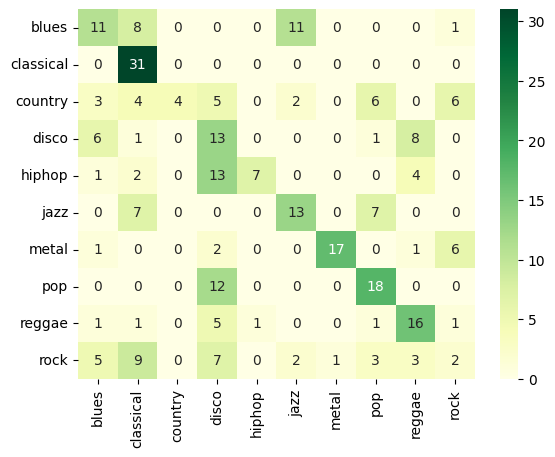

In [15]:
evaluate(speccnn_model, "best_speccnn_model_melspectrogram.ckpt", test_loader, device)

In [16]:
resnet_model = ResNet18() # ResNet-18
train(resnet_model, "best_resnet_model_melspectrogram.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


----------------------------------------
Epoch: [1/50], Train loss: 2.3955
Epoch: [1/50], Valid loss: 2.3073, Valid accuracy: 0.0812
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.1335
Epoch: [2/50], Valid loss: 2.1240, Valid accuracy: 0.2843
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 1.9365
Epoch: [3/50], Valid loss: 1.9931, Valid accuracy: 0.2843
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.7967
Epoch: [4/50], Valid loss: 1.9101, Valid accuracy: 0.3350
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.6978
Epoch: [5/50], Valid loss: 1.8816, Valid accuracy: 0.3198
-------------------------------

----------------------------------------
Model at best_resnet_model_melspectrogram.ckpt:
----------------------------------------
Accuracy: 0.5759
Precision: 0.5328
Recall: 0.5839
F1 Score: 0.5472


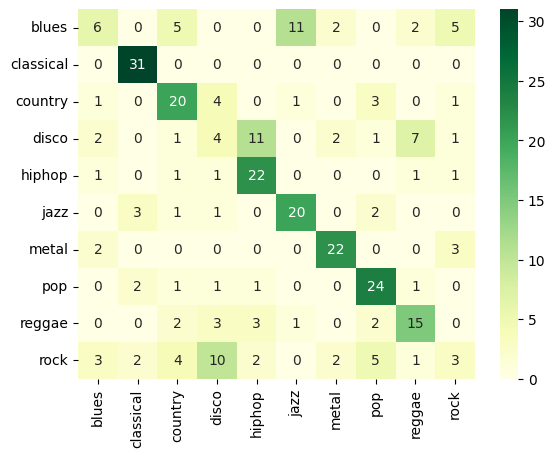

In [17]:
evaluate(resnet_model, "best_resnet_model_melspectrogram.ckpt", test_loader, device)

In [18]:
effnet_model = EfficientNetV2S() # EfficientNetv2-S
train(effnet_model, "best_effnet_model_melspectrogram.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 163MB/s]


----------------------------------------
Epoch: [1/50], Train loss: 2.2671
Epoch: [1/50], Valid loss: 2.2570, Valid accuracy: 0.1675
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.0468
Epoch: [2/50], Valid loss: 1.9998, Valid accuracy: 0.3858
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 1.8906
Epoch: [3/50], Valid loss: 1.8688, Valid accuracy: 0.4162
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.7604
Epoch: [4/50], Valid loss: 1.7926, Valid accuracy: 0.4670
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.6472
Epoch: [5/50], Valid loss: 1.7379, Valid accuracy: 0.4518
-------------------------------

----------------------------------------
Model at best_effnet_model_melspectrogram.ckpt:
----------------------------------------
Accuracy: 0.4759
Precision: 0.4677
Recall: 0.4850
F1 Score: 0.4618


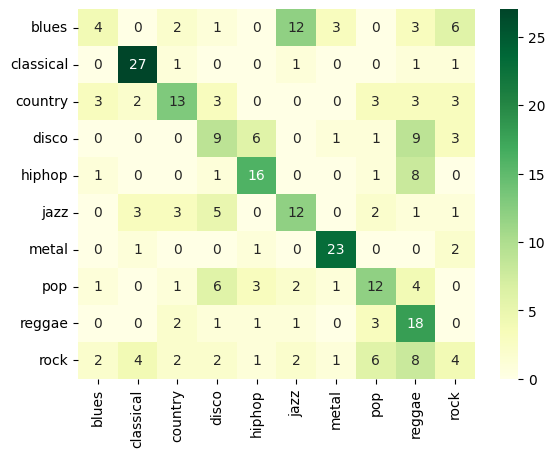

In [19]:
evaluate(effnet_model, "best_effnet_model_melspectrogram.ckpt", test_loader, device)

In [20]:
# Initialize the data loaders for spectrograms
train_loader = get_dataloader(split='train', selected_feature = "spectrogram")
valid_loader = get_dataloader(split='valid', selected_feature = "spectrogram")
test_loader = get_dataloader(split='test', selected_feature = "spectrogram")

# train_spectrogram, train_genre = next(iter(train_loader))
# test_spectrogram, test_genre = next(iter(test_loader))

# print('Training Mini-Batch Tensor Shape: %s' % str(train_melspectrogram.shape))
# print('Test Mini-Batch Tensor Shape: %s' % str(test_melspectrogram.shape))

In [21]:
speccnn_model = SpectrogramCNN() # Custom model built by us
train(speccnn_model, "best_speccnn_model_spectrogram.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

----------------------------------------
Epoch: [1/50], Train loss: 2.3476
Epoch: [1/50], Valid loss: 2.3532, Valid accuracy: 0.1015
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.1226
Epoch: [2/50], Valid loss: 2.2427, Valid accuracy: 0.2030
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 1.9534
Epoch: [3/50], Valid loss: 2.1090, Valid accuracy: 0.2234
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.9066
Epoch: [4/50], Valid loss: 2.0617, Valid accuracy: 0.2538
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.7968
Epoch: [5/50], Valid loss: 2.0515, Valid accuracy: 0.2386
-------------------------------

----------------------------------------
Model at best_speccnn_model_spectrogram.ckpt:
----------------------------------------
Accuracy: 0.5069
Precision: 0.5342
Recall: 0.5063
F1 Score: 0.4959


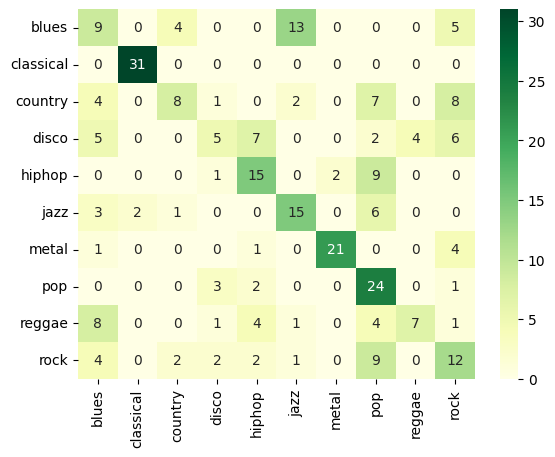

In [22]:
evaluate(speccnn_model, "best_speccnn_model_spectrogram.ckpt", test_loader, device)

In [23]:
resnet_model = ResNet18() # ResNet-18
train(resnet_model, "best_resnet_model_spectrogram.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

----------------------------------------
Epoch: [1/50], Train loss: 2.3556
Epoch: [1/50], Valid loss: 2.2668, Valid accuracy: 0.1472
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.0943
Epoch: [2/50], Valid loss: 2.0968, Valid accuracy: 0.2843
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 1.8901
Epoch: [3/50], Valid loss: 1.9381, Valid accuracy: 0.3807
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.7322
Epoch: [4/50], Valid loss: 1.8843, Valid accuracy: 0.3147
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.6034
Epoch: [5/50], Valid loss: 1.8213, Valid accuracy: 0.3959
-------------------------------

----------------------------------------
Model at best_resnet_model_spectrogram.ckpt:
----------------------------------------
Accuracy: 0.4793
Precision: 0.5030
Recall: 0.4857
F1 Score: 0.4850


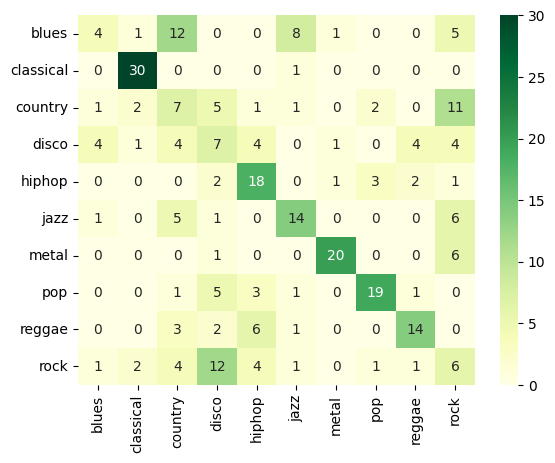

In [24]:
evaluate(resnet_model, "best_resnet_model_spectrogram.ckpt", test_loader, device)

In [25]:
effnet_model = EfficientNetV2S() # EfficientNetv2-S
train(effnet_model, "best_effnet_model_spectrogram.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

----------------------------------------
Epoch: [1/50], Train loss: 2.2556
Epoch: [1/50], Valid loss: 2.2398, Valid accuracy: 0.2437
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.0613
Epoch: [2/50], Valid loss: 2.0607, Valid accuracy: 0.3096
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 1.9198
Epoch: [3/50], Valid loss: 1.9549, Valid accuracy: 0.3553
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.8167
Epoch: [4/50], Valid loss: 1.9096, Valid accuracy: 0.3909
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.7358
Epoch: [5/50], Valid loss: 1.8527, Valid accuracy: 0.3959
-------------------------------

----------------------------------------
Model at best_effnet_model_spectrogram.ckpt:
----------------------------------------
Accuracy: 0.4828
Precision: 0.4611
Recall: 0.4920
F1 Score: 0.4639


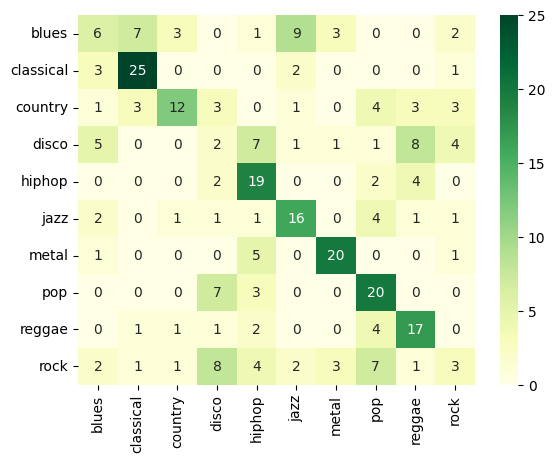

In [26]:
evaluate(effnet_model, "best_effnet_model_spectrogram.ckpt", test_loader, device)

In [27]:
# Initialize the data loaders for mfccs
train_loader = get_dataloader(split='train', selected_feature = "mfcc")
valid_loader = get_dataloader(split='valid', selected_feature = "mfcc")
test_loader = get_dataloader(split='test', selected_feature = "mfcc")

# train_spectrogram, train_genre = next(iter(train_loader))
# test_spectrogram, test_genre = next(iter(test_loader))

# print('Training Mini-Batch Tensor Shape: %s' % str(train_melspectrogram.shape))
# print('Test Mini-Batch Tensor Shape: %s' % str(test_melspectrogram.shape))

In [28]:
speccnn_model = SpectrogramCNN() # Custom model built by us
train(speccnn_model, "best_speccnn_model_mfcc.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

----------------------------------------
Epoch: [1/50], Train loss: 2.4066
Epoch: [1/50], Valid loss: 2.3220, Valid accuracy: 0.0863
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.2881
Epoch: [2/50], Valid loss: 2.2668, Valid accuracy: 0.1878
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 2.1422
Epoch: [3/50], Valid loss: 2.1297, Valid accuracy: 0.2589
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 2.0765
Epoch: [4/50], Valid loss: 2.0243, Valid accuracy: 0.2487
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.9848
Epoch: [5/50], Valid loss: 2.1202, Valid accuracy: 0.1523
-------------------------------

----------------------------------------
Model at best_speccnn_model_mfcc.ckpt:
----------------------------------------
Accuracy: 0.4724
Precision: 0.5242
Recall: 0.4782
F1 Score: 0.4646


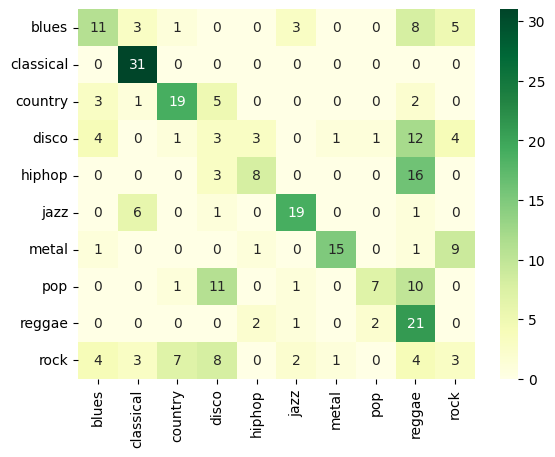

In [29]:
evaluate(speccnn_model, "best_speccnn_model_mfcc.ckpt", test_loader, device)

In [30]:
resnet_model = ResNet18() # ResNet-18
train(resnet_model, "best_resnet_model_mfcc.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

----------------------------------------
Epoch: [1/50], Train loss: 2.3303
Epoch: [1/50], Valid loss: 2.2937, Valid accuracy: 0.1371
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.0969
Epoch: [2/50], Valid loss: 2.1279, Valid accuracy: 0.2234
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 1.9504
Epoch: [3/50], Valid loss: 2.0178, Valid accuracy: 0.2843
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.8661
Epoch: [4/50], Valid loss: 1.9508, Valid accuracy: 0.3046
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.7613
Epoch: [5/50], Valid loss: 1.9537, Valid accuracy: 0.2843
-------------------------------

----------------------------------------
Model at best_resnet_model_mfcc.ckpt:
----------------------------------------
Accuracy: 0.5345
Precision: 0.5394
Recall: 0.5384
F1 Score: 0.5332


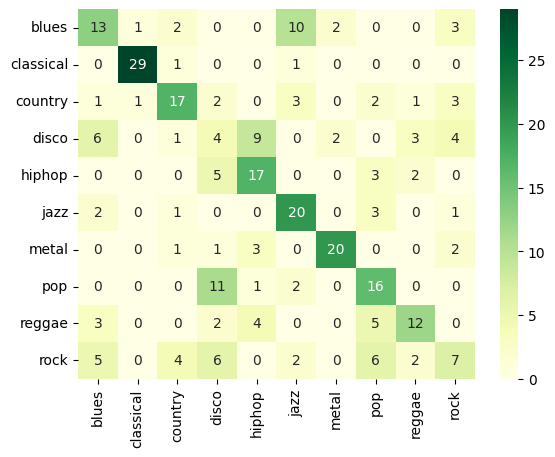

In [31]:
evaluate(resnet_model, "best_resnet_model_mfcc.ckpt", test_loader, device)

In [32]:
effnet_model = EfficientNetV2S() # EfficientNetv2-S
train(effnet_model, "best_effnet_model_mfcc.ckpt", train_loader, valid_loader, device, num_epochs=50, lr=1e-3, debug = True)

----------------------------------------
Epoch: [1/50], Train loss: 2.2662
Epoch: [1/50], Valid loss: 2.2680, Valid accuracy: 0.1777
----------------------------------------
Saving the best model at 0 epochs!
----------------------------------------
Epoch: [2/50], Train loss: 2.1213
Epoch: [2/50], Valid loss: 2.1392, Valid accuracy: 0.2487
----------------------------------------
Saving the best model at 1 epochs!
----------------------------------------
Epoch: [3/50], Train loss: 2.0286
Epoch: [3/50], Valid loss: 2.0662, Valid accuracy: 0.2640
----------------------------------------
Saving the best model at 2 epochs!
----------------------------------------
Epoch: [4/50], Train loss: 1.9275
Epoch: [4/50], Valid loss: 2.0285, Valid accuracy: 0.2437
----------------------------------------
Saving the best model at 3 epochs!
----------------------------------------
Epoch: [5/50], Train loss: 1.8642
Epoch: [5/50], Valid loss: 1.9819, Valid accuracy: 0.2893
-------------------------------

----------------------------------------
Model at best_effnet_model_mfcc.ckpt:
----------------------------------------
Accuracy: 0.4483
Precision: 0.4390
Recall: 0.4485
F1 Score: 0.4315


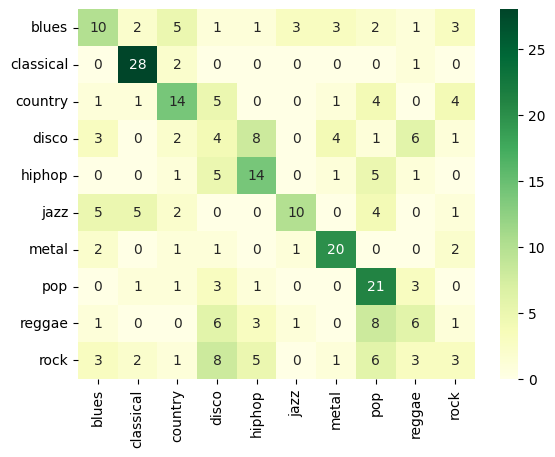

In [33]:
evaluate(effnet_model, "best_effnet_model_mfcc.ckpt", test_loader, device)